# EWC (Elastic Weight Consolidation)

Here’s the revised summary about this paper [Overcoming catastrophic forgetting in neural
networks](https://arxiv.org/pdf/1612.00796) | [Math proof](https://blog.csdn.net/dhaiuda/article/details/103967676) :
 
**Introduction**

Achieving continual learning, which allows artificial intelligence to learn new tasks without forgetting previous ones, is crucial. However, neural networks often face the issue of "catastrophic forgetting" when learning tasks sequentially, where the knowledge of previously learned tasks is overwritten when learning new ones.

The goal of this paper is to solve the problem of catastrophic forgetting and enable neural networks to switch between tasks effectively while retaining knowledge from previous tasks.

**Elastic Weight Consolidation (EWC)**

Humans and other animals have the ability to learn continuously without experiencing catastrophic forgetting, unlike artificial neural networks. Recent research shows that the mammalian brain prevents forgetting by protecting previously acquired knowledge within neocortical circuits. When a new skill is learned, a portion of excitatory synapses strengthens, leading to an increase in dendritic spine volume, which remains stable even when new tasks are learned, allowing for long-term retention of the skill. If these spines are selectively removed, the corresponding skill is forgotten, providing evidence that the stability of these synapses is essential for retaining learned tasks. This process, known as task-specific synaptic consolidation, is a key mechanism for continual learning, as modeled by neurobiological studies.

EWC is an algorithm that mimics synaptic consolidation by selectively constraining certain important parameters from being altered during the learning of new tasks. The importance of these parameters is measured using the Fisher Information Matrix, which adjusts the learning rate based on the parameters' significance for previous tasks.

**How EWC Works**:

- In a neural network, a quadratic penalty term is added to the loss function, which ensures that critical parameters remain close to their previous values. This prevents these parameters from being significantly changed during the learning of new tasks.
- As a result, EWC allows the network to learn new tasks (e.g., task B) while minimizing the loss of knowledge from previous tasks (e.g., task A).

**EWC Formula:**

The loss function $L(\theta)$ in EWC consists of two components:
1. The loss $L_B(\theta)$ for the new task B.
2. A penalty term related to the old task A.

The loss function is expressed as:
$L(\theta) = L_B(\theta) + \sum_{i} \frac{\lambda}{2} F_i (\theta_i - \theta_{A,i}^*)^2$
- $L_B(\theta)$: Loss for the current new task B.
- $\lambda$: A parameter that balances the importance of old and new tasks.
- $F_i$: The $i$-th diagonal element of the Fisher Information Matrix, representing the importance of parameter $\theta_i$ for the old task A.
- $\theta_{A,i}^*$: The optimal value of parameter $\theta_i$ for task A.

**Key Points:**

- **Penalty Term**: This quadratic penalty term ensures that the important parameters for previous tasks are kept close to their old values while learning new tasks.
- **Fisher Information Matrix**: Used to determine the importance of each weight for previous tasks, adjusting the strength of the penalty applied to each parameter.

These formulas and concepts help neural networks achieve continual learning by preventing the forgetting of old tasks while learning new ones.

My EWC codes are inspired by [HERE](https://github.com/db434/EWC)

I will set the following steps:

1. Loading data from dataset path and preprocessing them into the model-acceptable form.

2. Build a pre-train CNN model for fine-tuning and unfreezing.

3. Set a flexible optimizer for weights optimization during model training.

4. EWC (Elastic Weight Consolidation) technique introduction for next dataset within same model.

## Import libraries

In [2]:
import math
import numpy as np
import pandas as pd
from pathlib import Path
from copy import deepcopy
from functools import partial
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

time_now = lambda hours=0: dt.now() + relativedelta(hours=hours) # Set local time

# Record running time of notebook
print(f"Notebook is running at: {time_now()}")
print(f"Current working path: {Path.cwd()}")
print(f"TensorFlow version: {tf.__version__}")

# Dataset in C slot
# DATASET_DIR      = Path('C:\\Users\\User\\Desktop\\Data_Science_Notebook\\datasets')
# IMAGES_PATH      = DATASET_DIR.joinpath('Cats_and_Dogs_Breeds_Classification_Oxford_Dataset\\images\\images')
# TRAIN_VAL_PATH   = DATASET_DIR.joinpath('Cats_and_Dogs_Breeds_Classification_Oxford_Dataset\\annotations\\annotations\\trainval.txt')
# TEST_PATH        = DATASET_DIR.joinpath('Cats_and_Dogs_Breeds_Classification_Oxford_Dataset\\annotations\\annotations\\test.txt')
DATASET_DIR      = Path('datasets')
IMAGES_PATH      = DATASET_DIR / 'cropped_images'
TRAIN_VAL_PATH   = DATASET_DIR / 'annotations/trainval.txt'
TEST_PATH        = DATASET_DIR / 'annotations/test.txt'

print(f"\nImage Dataset Path: {IMAGES_PATH}")
print(f"TrainVal Dataset Path: {TRAIN_VAL_PATH}")
print(f"Test Dataset Path: {TEST_PATH}")


Notebook is running at: 2025-02-09 16:18:18.579900
Current working path: c:\Users\User\Desktop\cat_dog_project\model_training
TensorFlow version: 2.10.0

Image Dataset Path: datasets\cropped_images
TrainVal Dataset Path: datasets\annotations\trainval.txt
Test Dataset Path: datasets\annotations\test.txt


## Data Loader
This part I will create a class for data preprocessing.

In [3]:
from typing import List, Tuple, Any, Dict

class ImagePreprocessor:
    def __init__(self, img_size: int = 224):
        self.img_size = img_size
    
    def preprocess(self, image_path: str) -> tf.Tensor:
        """
        Takes an image file path and turns the image into a Tensor.

        Parameters:
            image_path (str): File path to the image.
        Returns:
            tf.Tensor: A preprocessed image tensor of shape (img_size, img_size, 3) with pixel values in the range [0, 1].
        """
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, size=[self.img_size, self.img_size])
        return image
    
class DataAugmentor:
    def __init__(self, img_size: int = 224):
        self.augmentor = Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomHeight(factor=0.2),
            layers.RandomWidth(factor=0.2),
            layers.RandomRotation(0.5),
            layers.RandomZoom(0.5),
            layers.Resizing(height=img_size, width=img_size)
        ], name='data_augmentation')

    def augment(self, image: tf.Tensor) -> tf.Tensor:
        return self.augmentor(image)

class DataLoader:
    def __init__(self, img_size: int = 224, batch_size: int = 32): 
        self.img_size = img_size
        self.batch_size = batch_size

        # Image preprocessing and data augmentation
        self.preprocessor = ImagePreprocessor(img_size=self.img_size)
        self.augmentor = DataAugmentor(img_size=self.img_size)

    def augment_data(self, image_path: str, label: Any) -> Tuple[tf.Tensor, Any]:
        """Augment image data via data augmentor."""
        image = self.preprocessor.preprocess(image_path)
        augmented_image = self.augmentor.augment(image)
        return augmented_image, label
    
    def preprocess_image_label(self, image_path: str, label: Any) -> Tuple[tf.Tensor, Any]:
        """Return preprocessed image and label."""
        image = self.preprocessor.preprocess(image_path)
        return image, label
    
    def extract_paths_and_labels(self) -> Tuple[List[Path], List[tf.Tensor]]:
        raise NotImplementedError
    
    def create_dataset(self, X, y=None, valid_data=None, test_data=None):
        """
        Create a TensorFlow dataset for training, validation, or testing.

        This function constructs a `tf.data.Dataset` for different types of datasets:
            - For test datasets, only the images are included, as labels are not available.
            - For validation datasets, images and labels are used without shuffling.
            - For training datasets, both images and labels are used with shuffling enabled.

        Parameters:
            X (array-like): Input data, typically image paths or image data.
            y (array-like, optional): Labels corresponding to the input data. Defaults to None for test data where labels are not needed.
            valid_data (bool, optional): If `True`, indicates that the dataset is for validation. Defaults to `None`.
            test_data (bool, optional): If `True`, indicates that the dataset is for testing (labels are not included). Defaults to `None`.
        Returns:
            tf.data.Dataset:
                A TensorFlow dataset prepared for training, validation, or testing, with the appropriate processing steps applied.
        """
        # If the data is a valid or test dataset, we don't need to shuffle it
        if valid_data or test_data:
            data_batch = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) \
                        .map(self.preprocess_image_label, num_parallel_calls=tf.data.AUTOTUNE) \
                        .batch(self.batch_size) \
                        .prefetch(buffer_size=tf.data.AUTOTUNE)
            return data_batch

        else:
            # Create a dataset containing original and augmented data
            # Dataset for original images
            original_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) \
                               .map(self.preprocess_image_label, num_parallel_calls=tf.data.AUTOTUNE) \
                                
            # Dataset for augmented images
            augmented_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) \
                                .map(self.augment_data, num_parallel_calls=tf.data.AUTOTUNE)

            # Zip the two datasets together
            combined_data = original_dataset.concatenate(augmented_dataset)

            shuffle_buffer_size = len(X)
            combined_data_batch = combined_data.shuffle(shuffle_buffer_size, reshuffle_each_iteration=True) \
                                               .batch(self.batch_size) \
                                               .prefetch(buffer_size=tf.data.AUTOTUNE)
            return combined_data_batch
    
class CatDogDataLoader(DataLoader):
    def __init__(self, 
                 img_dir: Path, train_val_path = None, test_path = './test_images',
                 img_size: int = 224, batch_size: int = 32, 
                 val_split: float = 0.1,
                 cls_limit: int = 0):
        super(CatDogDataLoader, self).__init__(img_size=img_size, batch_size=batch_size)
        self.img_dir        = img_dir
        self.train_val_path =  train_val_path
        self.test_path      = test_path
        self.val_split      = val_split
        self.cls_limit      = cls_limit
        self.separate_data_by_species = lambda df, cls_idx: df[df['SPECIES'] == str(cls_idx)]

        # Initialize label mapping nad category list
        self.label_to_index: Dict[str, Dict] = {'cats': {}, 'dogs': {}}
        self.category_map: Dict[str, List] = {'cats': [], 'dogs': []}
    
    def get_categories(self, species: str) -> Any:
        """Category getter by category map."""
        return self.category_map.get(species, 'None')

    def load_data(self, dataset_path) -> pd.DataFrame:
        df = pd.read_csv(dataset_path, header=None, encoding='utf-8')
        df = df[0].str.split(" ", expand=True)
        df.columns = ["IMAGE", "CLASS_ID", "SPECIES", "BREED_ID"]
        df['IMAGE'] = df['IMAGE'].apply(lambda x: str(x) + '.jpg')
        df['CLASSNAME'] = df['IMAGE'].apply(lambda x: ' '.join(str(x).split('_')[:-1]))
        
        return df
    
    def extract_paths_and_labels(self, df: pd.DataFrame, species_name: str, test_data=False) -> Tuple[List[Path], List[tf.Tensor]]:
        img_paths = [str(self.img_dir / img_name) for img_name in df['IMAGE'].values]
        img_classes = [cls_name for cls_name in df['CLASSNAME'].values]
        
        if not test_data:
            if self.cls_limit > 0:
                self.categories = np.unique(np.array(img_classes))[:self.cls_limit]
            else:
                self.categories = np.unique(np.array(img_classes))
            self.category_map[species_name] = self.categories
            print(f"------{species_name.capitalize()} categories:------\n[{', '.join(self.categories)}]")

            self.label_to_index[species_name] = {category:idx for idx, category in enumerate(self.categories, start=0)}

        # Use filter to select only the items that match the selected categories
        filter_items = [(img_path, img_class)
                        for img_path, img_class in zip(img_paths, img_classes)
                        if img_class in self.categories]
        filtered_img_paths, filtered_img_classes = zip(*filter_items)

        label_counter = {}
        for imgCls in filtered_img_classes:
            if imgCls not in label_counter:
                label_counter[imgCls] = 0
            label_counter[imgCls] += 1
        print(f"{'Test' if test_data else 'Train_Val'} label distribution: {label_counter}")

        # Generate one-hot encoded labels for the filtered classes
        filtered_one_hot_labels = [
            tf.one_hot(self.label_to_index[species_name][cls_name], len(self.categories)).numpy()
            for cls_name in filtered_img_classes
        ]
        
        return (list(filtered_img_paths), filtered_one_hot_labels)
   
    def run(self, species_idx, species_list: List[str] = ['cats', 'dogs']):
        species = species_list[species_idx]
        train_val_df = self.load_data(dataset_path=self.train_val_path)
        self.train_val_species_df = self.separate_data_by_species(train_val_df, species_idx+1)

        # Split and create training and validation datasets
        img_paths, label_one_hot = self.extract_paths_and_labels(self.train_val_species_df, species)
        train_paths, val_paths, train_labels, val_labels = \
                    train_test_split(img_paths, label_one_hot, test_size=self.val_split, random_state=42)
        train_dataset = self.create_dataset(train_paths, train_labels)
        val_dataset = self.create_dataset(val_paths, val_labels, valid_data=True)

        # Split data for training, validation, and prepare test data
        test_df = self.load_data(dataset_path=self.test_path)
        self.test_species_df = self.separate_data_by_species(test_df, species_idx+1)
        test_paths, test_classes = self.extract_paths_and_labels(self.test_species_df, species, test_data=True)
        test_dataset = self.create_dataset(test_paths, test_classes, test_data=True)
        
        return (train_dataset, val_dataset, test_dataset)
        

In [5]:
cls_limit        = 3
BATCH_SIZE       = 16
validation_split = 0.1
species_list     = ['cats', 'dogs']

data_loader = CatDogDataLoader(img_dir=IMAGES_PATH, train_val_path=TRAIN_VAL_PATH, test_path=TEST_PATH, 
                               img_size=224, batch_size=BATCH_SIZE, val_split=validation_split, 
                               cls_limit=cls_limit)
cat_train_dataset, cat_val_dataset, cat_test_dataset = data_loader.run(species_idx=0, species_list=species_list)
dog_train_dataset, dog_val_dataset, dog_test_dataset = data_loader.run(species_idx=1, species_list=species_list)

------Cats categories:------
[Abyssinian, Bengal, Birman]
Train_Val label distribution: {'Abyssinian': 100, 'Bengal': 100, 'Birman': 100}
Test label distribution: {'Abyssinian': 98, 'Bengal': 100, 'Birman': 100}
------Dogs categories:------
[american bulldog, american pit bull terrier, basset hound]
Train_Val label distribution: {'american bulldog': 100, 'american pit bull terrier': 100, 'basset hound': 100}
Test label distribution: {'american bulldog': 100, 'american pit bull terrier': 100, 'basset hound': 100}


In [6]:
len(cat_train_dataset), len(cat_val_dataset), len(cat_test_dataset), len(dog_train_dataset), len(dog_val_dataset), len(dog_test_dataset)

(34, 2, 19, 34, 2, 19)

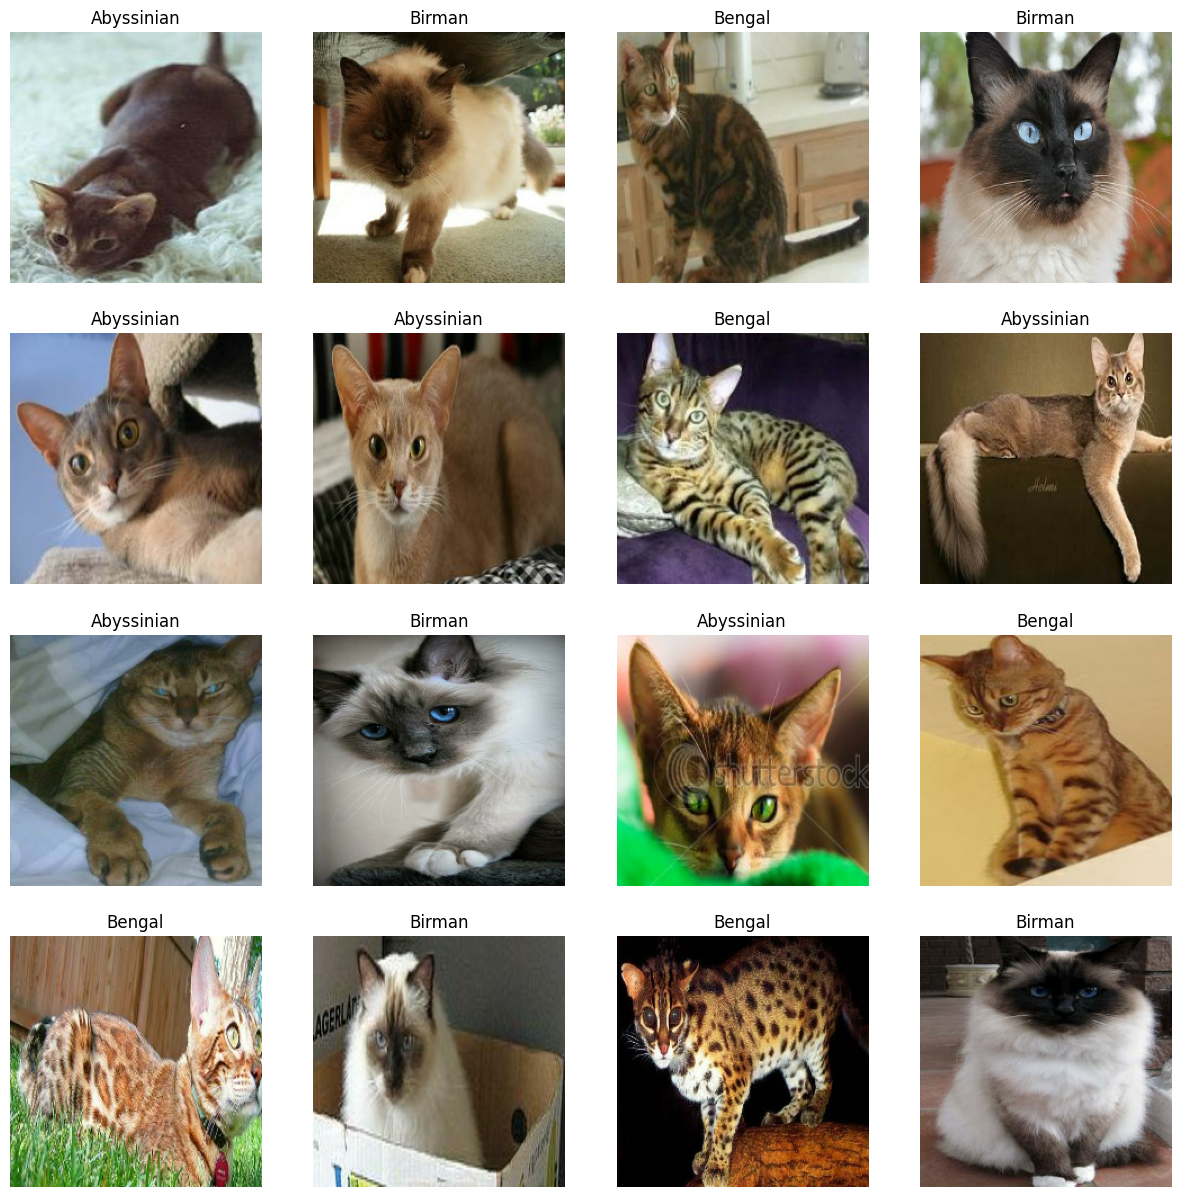

In [7]:
cats_train_data = next(cat_train_dataset.as_numpy_iterator())
cats_names = data_loader.get_categories('cats')

plt.figure(figsize=(15, 15))
for i in range(len(cats_train_data[0])):
    plt.subplot(4, 4, i+1)
    plt.imshow(cats_train_data[0][i])
    plt.title(cats_names[np.argmax(cats_train_data[1][i])])
    plt.axis('off')
plt.show()

## EWC algorithm

In this part I will create a class to introduce EWC for fisher matrix calculation.

In [8]:
def compute_fisher(prior_model, dataset, samples=50) -> np.array:
    weights = prior_model.trainable_variables # Trainable variables (weights) of the model
    
    # Initialize Fisher matrix accumulator with zeros for each weight shape
    fisher_matrix = np.array([np.zeros_like(weight) for weight in weights], dtype=object)

    # Loop over the number of samples to estimate Fisher matrix
    for idx, data_sample in enumerate(dataset.take(samples)):
        progress = int((idx + 1) / samples * 50)
        print(f"\r[{'=' * progress}>{'.' * (50 - progress)}] {idx + 1}/{samples}", end="", flush=True)

        inputs, _ = data_sample
        # Compute log-softmax of the model's output
        with tf.GradientTape() as tape:
            outputs = prior_model(inputs)
            log_likelihood = tf.nn.log_softmax(outputs)
            # log_likelihood = tf.math.log(outputs)
        
        # Compute gradients of the logits with respect to the weights
        gradients = tape.gradient(log_likelihood, weights)
        
        # Accumulate the squared gradients into the Fisher matrix
        fisher_matrix = [var + (grad ** 2) for var, grad in zip(fisher_matrix, gradients)]
                
    # Normalization
    fisher_matrix = [f / samples for f in fisher_matrix]
    return fisher_matrix
    
def EWC_penalty_loss(fisher_diagonal, prior_model, lambda_):
    optimal_weights = deepcopy(prior_model.trainable_variables)

    def loss_fn(new_model):
        """
        Calculate:
            sum [(lambda / 2) * F * (current weights - optimal weights)^2]
        """
        penalty = 0
        current_weights = new_model.trainable_variables
        for fd, cw, ow in zip(fisher_diagonal, current_weights, optimal_weights):
            penalty += tf.reduce_sum(fd * tf.math.square(cw - ow))
        
        return (0.5 * lambda_) * penalty
    
    return loss_fn

FIM_mask = lambda fisher_diagonal, threshold: [tensor < threshold for tensor in fisher_diagonal]

def combine_masks(mask1, mask2):
    """有三個以上數據集適用"""
    if mask1 is None:
        return mask2
    elif mask2:
        return mask1
    else:
        return [tf.logical_and(tensor1, tensor2) 
                for tensor1, tensor2 in zip(mask1, mask2)]

def apply_mask(gradients, mask):
    if mask is not None:
        gradients = [grad * tf.cast(mask, tf.float32)
                    for grad, mask in zip(gradients, mask)]
    return gradients

def clip_gradients(gradients: List[tf.Tensor], threshold: float):
    """
    Applies gradient clipping (IncDet) to prevent instability in training due to large gradients. 
    This method is especially useful when dealing with quadratic loss functions, such as 
    those used in Elastic Weight Consolidation (EWC), which can result in gradients 
    growing very large and destabilizing training. The clipping process reduces 
    gradients above a certain threshold, making them linear instead of quadratic.
    https://ieeexplore.ieee.org/document/9127478

    Parameters:
        gradients (List[tf.Tensor]): List of gradients of the model's trainable weights.
        threshold (float): The value beyond which gradients will be clipped. Gradients 
                        larger than this value will be scaled down.

    Returns:
        List[tf.Tensor]: The gradients after clipping, with values scaled according to 
                        the threshold. Gradients that are below the threshold remain unchanged.
    """
    # We scale each gradient g by: b / (max(b, |g|))
    result = []
    for tensor in gradients:
        scale = threshold / tf.math.maximum(threshold, tf.math.abs(tensor))
        result.append(tensor * scale)
    
    return result
    

## Model Training

In this part I will create several functions or objects for model training.

In [9]:
def show_config(**kwargs):
    """
    Show all the configuration about training.
    """
    print('Configurations:')
    print('-' * 70)
    print('|%25s | %40s|' % ('keys', 'values'))
    print('-' * 70)
    for key, value in kwargs.items():
        print('|%25s | %40s|' % (str(key), str(value)))
    print('-' * 70)

### Training Curve Plotting

In [10]:
def plot_loss_curves(history, model_freezed_line=0):
    """Returns separate loss curves for training and validation metrics."""

    # epochs
    epochs = history['epochs']

    # losses and accuracy
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    train_accuracy = history['train_acc']
    val_accuracy = history['val_acc']
    learning_rates = history['lr']  # Add this line
    
    # plot loss and accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    if model_freezed_line:
        plt.plot([model_freezed_line, model_freezed_line], plt.ylim(), label='Model Freeze')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    if model_freezed_line:
        plt.plot([model_freezed_line, model_freezed_line], plt.ylim(), label='Model Freeze')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

    # Plot the learning rate schedule
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, learning_rates, marker='o', label="Learning Rate")
    plt.title("Learning Rate Schedule", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Learning Rate", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

### Learning rate scheduler

Create functions for accuracy calculation and learning rate decay.

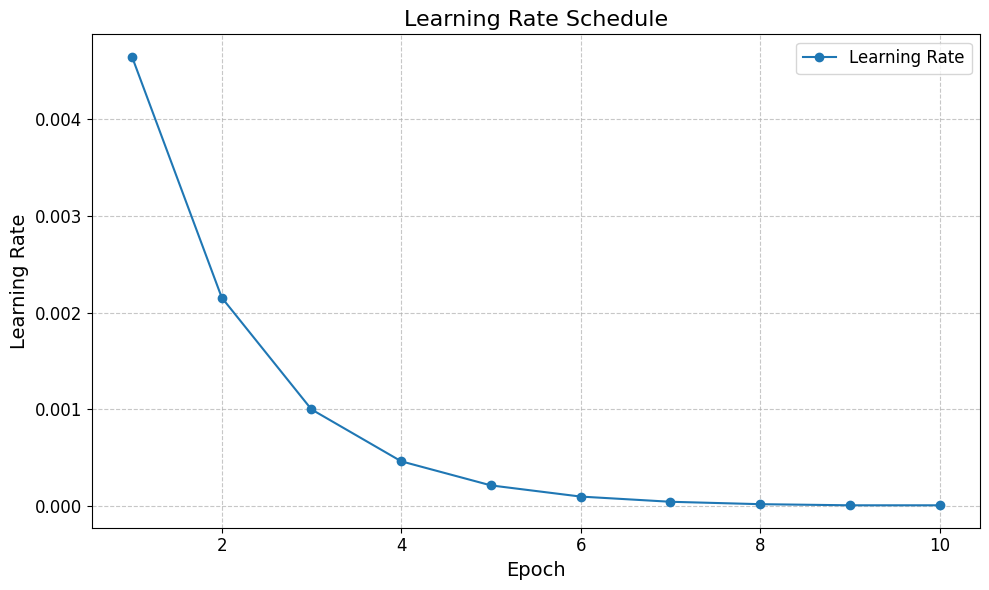

In [11]:
def get_lr_scheduler(initial_lr: float, 
                     min_lr: float, 
                     total_iters: int, 
                     step_num: int = 10, 
                     scheduler_type: str = "step",
                     warmup_total_iters: int = 0, 
                     decay_rate: float = 0.8, 
                     alpha = 1.5, 
                     factor = 0.8):
    """
    Returns a learning rate scheduler function based on the selected scheduler type.

    Parameters:
        lr (float): Initial learning rate.
        min_lr (float): Minimum learning rate, the decay stops at this value.
        total_iters (int): Total number of iterations for training.
        step_num (int): Number of steps to divide the iterations into (default is 10).
        scheduler_type (str): Type of scheduler to use ("step", "cosine_annealing", "constant").
        warmup_total_iters (int): Number of iterations for the warmup phase (default is 0).

    Returns:
        func (callable): A function to compute the learning rate based on the current iteration.
    """
    if scheduler_type == "step":
        def step_lr(initial_lr, decay_rate, step_size, iters):
            """
            Computes the learning rate using step-wise exponential decay.

            Parameters:
                initial_lr (float): Initial learning rate.
                decay_rate (float): Decay rate per step.
                step_size (float): Number of iterations per step.
                iters (int): Current iteration number.

            Returns:
                out_lr (float): Learning rate for the current iteration.
            """
            if step_size < 1:
                raise ValueError("step_size must be greater than 1.")
            n = iters // step_size         # The current step number.
            out_lr = initial_lr * decay_rate ** n  # Exponential decay based on the step number.
            return max(out_lr, min_lr)

        decay_rate = (min_lr / initial_lr) ** (1 / (step_num - 1))  # The decay rate for each step.
        step_size = total_iters / step_num                 # The number of iterations per step.
        return partial(step_lr, initial_lr, decay_rate, step_size)

    elif scheduler_type == "cosine_annealing":
        def cosine_annealing_lr(initial_lr, min_lr, warmup_total_iters, total_iters, alpha, factor, iters):
            """
            Computes the learning rate using cosine annealing with warmup.

            Parameters:
                initial_lr (float): Initial learning rate.
                min_lr (float): Minimum learning rate.
                warmup_total_iters (int): Number of iterations for the warmup phase.
                total_iters (int): Total number of iterations for training.
                iters (int): Current iteration number.

            Returns:
                out_lr (float): Learning rate for the current iteration.
            """
            # if iters < warmup_total_iters:
            #     out_lr = initial_lr + (initial_lr * (iters / warmup_total_iters))  # Linear warmup
            # else:
            #     adjusted_initial_lr = initial_lr * factor
            #     adjusted_iters = iters - warmup_total_iters
            #     adjusted_total_iters = total_iters - warmup_total_iters
            #     cos_decay = 0.5 * (1 + math.cos(math.pi * (adjusted_iters / adjusted_total_iters) ** alpha ))
            #     # out_lr = min_lr + (initial_lr - min_lr) * cos_decay
            #     out_lr = min_lr + (adjusted_initial_lr - min_lr) * cos_decay

            # return out_lr
            if iters < warmup_total_iters:
                # 線性 Warmup，平穩提升學習率
                out_lr = initial_lr + (initial_lr - min_lr) * (iters / warmup_total_iters)
            else:
                # 調整起始學習率，使其下降較緩慢
                adjusted_initial_lr = initial_lr * factor
                adjusted_iters = iters - warmup_total_iters
                adjusted_total_iters = total_iters - warmup_total_iters
                
                # 使用 alpha 調整餘弦衰減速度
                cos_decay = 0.5 * (1 + math.cos(math.pi * (adjusted_iters / adjusted_total_iters) ** alpha))
                
                # 最終學習率
                out_lr = min_lr + (adjusted_initial_lr - min_lr) * cos_decay

            return out_lr

        return partial(cosine_annealing_lr, initial_lr, min_lr, warmup_total_iters, total_iters, alpha, factor)

    elif scheduler_type == "constant":
        def constant_lr(initial_lr, iters):
            """
            Returns a constant learning rate regardless of iteration.

            Parameters:
                lr (float): Initial learning rate.
                iters (int): Current iteration number (ignored).

            Returns:
                lr (float): Constant learning rate.
            """
            return initial_lr

        return partial(constant_lr, initial_lr)
    
    elif scheduler_type == 'exponential':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_lr,
            decay_steps=step_num,
            decay_rate=decay_rate,
            staircase=True  # If True, the decay occurs at discrete intervals
        )
        return lr_schedule
    
    else:
        raise ValueError(f"Unsupported scheduler_type: {scheduler_type}. Choose from 'step', 'cosine_annealing', or 'constant'.")

SHOW = True
if SHOW:
    scheduler_type = 'step'
    
    # Parameters for the learning rate schedule
    initial_lr = 1e-2
    min_lr = 1e-5
    warmup_total_iters = 5
    total_epochs = 10
    step_num = 10
    decay_rate = 0.8
    alpha = 0.5
    factor = 2

    # Generate the learning rate scheduler
    lr_scheduler = get_lr_scheduler(
        initial_lr         = initial_lr, 
        min_lr             = min_lr, 
        total_iters        = total_epochs,
        step_num           = step_num,
        scheduler_type     = scheduler_type,
        warmup_total_iters = warmup_total_iters,
        decay_rate         = decay_rate,
        alpha              = alpha,
        factor             = factor
    )

    # Calculate learning rates for each epoch
    epochs = np.arange(1, total_epochs + 1)  # Epoch indices
    learning_rates = [lr_scheduler(epoch) for epoch in epochs]

    # Plot the learning rate schedule
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, learning_rates, marker='o', label="Learning Rate")
    plt.title("Learning Rate Schedule", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Learning Rate", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


### Model Building


In [12]:
class AnimalClassifier(tf.keras.Model):
    """MobileNetV2-based classifier for animal classification."""
    
    def __init__(self, 
                 input_feature: Tuple[int], output_dimension: int, model_name: str = 'animal_classifier'):
        """
        Create a transfer learning model based on MobileNetV2 for animal classification.

        Parameters:
            input_feature (List[int]): Shape of the input image (height, width, channels).
            output_dimension (int): Number of output classes.
            model_name (str): Name of the model (optional).
        """
        super(AnimalClassifier, self).__init__(name=model_name)

        self.input_feature = input_feature
        self.output_dimension = output_dimension

        # Define the model
        self.model = tf.keras.Sequential([
            tf.keras.applications.MobileNet(input_shape=self.input_feature, include_top=False),
            # tf.keras.layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same', name='convolution_layer'),
            # tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), name='maximum_pooling_layer'),  
            tf.keras.layers.Dense(64, activation="relu", name="dense_layer", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(32, activation="relu", name="dense_layer_2", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(16, activation="relu", name="dense_layer_3", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(8, activation="relu", name="dense_layer_4", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer"),
            tf.keras.layers.Dense(output_dimension, activation="softmax", name="output_layer")
        ])
        
        self.model.layers[0].trainable = False  # Freeze the pre-trained weights

    def call(self, inputs, training=False, mask=None):
        """Forward pass of the model."""
        return self.model.call(inputs, training, mask)

    def get_config(self):
        """
        Get the model configuration for serialization.
        """
        return {
            "input_feature": self.input_feature,
            "output_dimension": self.output_dimension,
            "model_name": self.name
        }

    @classmethod
    def from_config(cls, config):
        """
        Create a new model instance from the given configuration.
        """
        return cls(**config)

def compiled_model(model: tf.keras.Model, 
                       learning_rate, 
                       extra_loss_fn=None) -> tf.keras.Model:
    loss_fn = CategoricalCrossentropy()
    def custom_loss_fn(y_true, y_pred):
        loss = loss_fn(y_true, y_pred)
        if extra_loss_fn is not None:
            loss += extra_loss_fn(model)
        
        return loss

    model.compile(loss=custom_loss_fn, optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])


### Accuracy Calculation

In [13]:
def calculate_accuracy(y_true:tf.Tensor, y_pred:tf.Tensor) -> np.float32:
    """
    Create accuracy score via true labels and model predictions.

    Args:
        y_true: True labels from dataset
        y_pred: Model predictions
    Returns:
        Accuracy score
    """
    results = tf.equal(tf.argmax(y_pred, axis=1), tf.argmax(y_true, axis=1))
    results_to_float = tf.cast(results, tf.float32)
    accuracy_score = tf.reduce_mean(results_to_float).numpy()

    return accuracy_score


### History Recorder

In [14]:
class Recorder:
      def __init__(self, keys=None):
            if keys is None:
                  keys = ['epochs', 'lr', 'train_loss', 'train_acc', 'val_loss', 'val_acc']
            self.history = {key: [] for key in keys}

      def record_epoch(self, **kwargs):
            for key, value in kwargs.items():
                  if key in self.history:
                        self.history[key].append(value)
                  else:
                        raise KeyError(f"Key '{key}' not found in Recorder history. Please add it to the initialization keys.")

      def get_history(self):
            return self.history

### Training And Testing Handler

In [15]:
def train_one_epoch(model, train_dataset, 
                    gradient_mask=None, IncDet_threshold=None):
      losses, accuracies = [], []
      total_samples = len(train_dataset) # for pretty print

      for idx, (inputs, labels) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                  preds = model(inputs)
                  loss = model.compiled_loss(labels, preds)
            
            # Compute gradients and apply optimization
            gradients = tape.gradient(loss, model.trainable_variables)

            # Don't allow gradients to propagate to weights which are important.
            if gradient_mask is not None:
                  gradients = apply_mask(gradients, gradient_mask)

            # Squash some of the very large gradients which EWC can create.
            if IncDet_threshold is not None:
                  gradients = clip_gradients(gradients, IncDet_threshold)

            model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            # Training loss and accuracy
            loss = loss.numpy()
            accuracy = calculate_accuracy(labels, preds)

            losses.append(loss) 
            accuracies.append(accuracy)

            progress = int((idx + 1) / total_samples * 50)
            print(f"\r[{'=' * (progress-1)}{'>'}{'.' * (50 - progress)}] {idx + 1}/{total_samples}", end="\r", flush=True)
      print()

      return np.round(np.mean(losses), 5), np.round(np.mean(accuracies), 5)

def validate(model, val_dataset):
      losses, accuracies = [], []
      total_samples = len(val_dataset) # for pretty print
    
      for idx, (inputs, labels) in enumerate(val_dataset):
            preds = model(inputs)

            # Training loss and accuracy
            loss = model.compiled_loss(labels, preds).numpy()
            accuracy = calculate_accuracy(labels, preds)

            losses.append(loss) 
            accuracies.append(accuracy)

            progress = int((idx + 1) / total_samples * 50)
            print(f"\r[{'=' * (progress-1)}{'>'}{'.' * (50 - progress)}] {idx + 1}/{total_samples}", end="\r", flush=True)

      return np.round(np.mean(losses), 5), np.round(np.mean(accuracies), 5)

def test_model(model, test_datasets):
    results = {}
    print('Model Evaluation...')
    dataset_A, dataset_B = test_datasets
    print("Dataset A Testing Loss | Accuracy")
    results['Dataset_A'] = model.evaluate(dataset_A)
    print("Dataset B Testing Loss | Accuracy")
    results['Dataset_B'] = model.evaluate(dataset_B)

    return results

### Optimization Handler

In [16]:
class OptimizationController:
    """
    A class to encapsulate optimization-related logic such as fine-tuning (layer unfreezing), 
    learning rate scheduling, and early stopping.
    """
    def __init__(self, unfreeze_ratio, lr_scheduler, patience_for_stopping, fine_tune_epoch=-1, start_opt=0):
        """
        Initialize the OptimizationController.

        Args:
            unfreeze_ratio (float): The ratio of layers to unfreeze for fine-tuning.
            lr_scheduler (callable): A function that takes the current epoch and returns a new learning rate.
            patience_for_lr_decay (int): Number of epochs with no improvement before adjusting the learning rate.
            unfreeze_fn (callable): A function that unfreezes partial layers of base model of model.
        """
        self.unfreeze_ratio = unfreeze_ratio
        self.lr_scheduler = lr_scheduler
        self.patience_for_stopping = patience_for_stopping
        self.fine_tune_epoch = fine_tune_epoch
        self.start_opt = start_opt
        
        self.has_unfreezed = False
        self.best_val_acc = 0.0
        self.improvement_counter  = 0
    
    def unfreezing_model(self, model):
        """
        Adjusts the trainable status of a portion of the base model's layers for fine-tuning.
        This function selectively unfreezes a specified percentage of the base model's layers for further training.

        Parameters:
            model (tf.keras.Model): The complete model containing the base model and additional layers.
        """
        # Calculate the number of layers to unfreeze
        unfreeze_base_model = model.model.layers[0]
        num_layers = len(unfreeze_base_model.layers)
        layer_number = max(-num_layers, -int(num_layers * self.unfreeze_ratio))

        # Unfreeze all layers initially, then refreeze the layers up to the calculated layer number
        unfreeze_base_model.trainable = True
        for layer in unfreeze_base_model.layers[:layer_number]:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = False
        self.has_unfreezed = True
    
    def update(self, val_acc, model, epoch, cur_lr):
        """
        Update the optimization state based on the validation accuracy, and adjust learning rate or trigger early stopping if needed.

        Args:
            val_loss (float): The current epoch's validation accuracy.
            model: The TensorFlow model.
            epoch (int): The current epoch number.
            cur_lr (float): The current learning rate.

        Returns:
            tuple: (should_stop, new_lr) where should_stop is True if early stopping is triggered,
                   and new_lr is the potentially updated learning rate.
        """
        stop = False
        new_lr = cur_lr
        # Model unfreezing
        if (epoch == self.fine_tune_epoch) and (not self.has_unfreezed):
            self.unfreezing_model(model)
            self.best_val_acc = 0
            new_lr = cur_lr * 0.1
            compiled_model(model, learning_rate=new_lr)
            print(f"\nUnfroze the last {self.unfreeze_ratio:.0%} layers of the base model in next epoch.")

            return new_lr, stop
        
        # Learning rate scheduler
        if (self.start_opt > 0) and (epoch >= self.start_opt) :
            if not self.has_unfreezed:
                new_lr = self.lr_scheduler(epoch)

        # Early stopping
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.improvement_counter = 0
        else:
            self.improvement_counter += 1
            if self.improvement_counter >= self.patience_for_stopping:
                stop = True
        
        # Update learning rate
        tf.keras.backend.set_value(model.optimizer.learning_rate, new_lr)

        return new_lr, stop


### First Dataset Trainer

In [17]:
def train(model, epochs, initial_learning_rate, fine_tune_epoch, start_opt,  
          train_dataset, val_dataset, test_datasets: Tuple[tf.data.Dataset], 
          unfreeze_ratio=None, lr_scheduler=None, patience_for_stopping=None):
      """Train model with first dataset."""
      # Variable Initialization
      compiled_model(model, learning_rate=initial_learning_rate)
      print(model.model.summary())
      history = Recorder(keys=['epochs', 'lr', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])
      optimization_controller = OptimizationController(unfreeze_ratio, lr_scheduler, patience_for_stopping,
                                                       fine_tune_epoch=fine_tune_epoch, start_opt=start_opt)
      current_lr = model.optimizer.learning_rate.numpy()

      # Start Training
      for epoch in range(1, epochs+1):
            print(f"\nEpoch: {str(epoch)}/{str(epochs)}")
            train_loss, train_acc = train_one_epoch(model, train_dataset)
            val_loss, val_acc = validate(model, val_dataset)
            print(f"Training Loss: {train_loss:.5f} Training Accuracy: {train_acc:.5f} Validation Loss: {val_loss:.5f} Validation Accuracy: {val_acc:.5f} Learning Rate: {current_lr:.8f}")

            # record all the results of each epoch
            history.record_epoch(epochs=epoch, lr=current_lr,
                                 train_loss=train_loss, train_acc=train_acc, 
                                 val_loss=val_loss, val_acc=val_acc)

            # Model parameters unfreezing training
            current_lr, stop = optimization_controller.update(val_acc, model, epoch, current_lr)
            if stop:
                  print(f"Early stopping triggered at epoch {epoch}")
                  break
      _ = test_model(model, test_datasets=test_datasets)

      return history.get_history()



### Second Dataset Trainer

In [18]:
def train_increment(model, epochs, initial_learning_rate, fine_tune_epoch, start_opt,
                    prior_train_dataset, train_dataset, val_dataset, test_datasets: Tuple[tf.data.Dataset], 
                    unfreeze_ratio=None, lr_scheduler=None, patience_for_stopping=None, 
                    apply_ewc=False, ewc_lambda=1, ewc_samples=100,
                    apply_fim=False, fim_threshold=1e-4,
                    apply_IncDet=False, IncDet_threshold=1e-6):
      # Variable initialization
      compiled_model(model, learning_rate=initial_learning_rate)
      history = Recorder(keys=['epochs', 'lr', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'fisher_diagonal'])
      optimization_controller = OptimizationController(unfreeze_ratio, lr_scheduler, patience_for_stopping,
                                                      fine_tune_epoch=fine_tune_epoch, start_opt=start_opt)
      
      # Learning rate initialization
      current_lr = initial_learning_rate
      tf.keras.backend.set_value(model.optimizer.learning_rate, current_lr)
      
      # Increment-related variables initialization
      penalty_loss_fn = None
      gradient_mask = None
      IncDet_threshold = None if (not apply_IncDet) else IncDet_threshold
      
      # EWC process
      print('\nCalculating fisher diagonal matrix...')
      fisher_diagonal = compute_fisher(prior_model=model, dataset=prior_train_dataset, samples=ewc_samples)
      if apply_ewc:
            # If EWC is used, generate a loss function that adds a penalty when the model deviates 
            # from its current state. This is to preserve performance on the current dataset, which may not reappear.
            penalty_loss_fn = EWC_penalty_loss(fisher_diagonal=fisher_diagonal, prior_model=model, lambda_=ewc_lambda)
            compiled_model(model, current_lr, extra_loss_fn=penalty_loss_fn)
      if apply_fim:
            # If FIM is used, determine which weights need to be frozen in order to preserve performance 
            # on the current dataset.
            gradient_mask = FIM_mask(fisher_diagonal=fisher_diagonal, threshold=fim_threshold)
            history.record_epoch(fisher_diagonal=fisher_diagonal)

      # Start Training
      for epoch in range(1, epochs+1):
            print(f"\nEpoch: {str(epoch)}/{str(epochs)}")
            train_loss, train_acc = train_one_epoch(model, train_dataset, 
                                                    gradient_mask=gradient_mask, IncDet_threshold=IncDet_threshold)
            val_loss, val_acc = validate(model, val_dataset)
            print(f"Training Loss: {train_loss:.5f} Training Accuracy: {train_acc:.5f} Validation Loss: {val_loss:.5f} Validation Accuracy: {val_acc:.5f} Learning Rate: {current_lr:.8f}")

            # record all the results of each epoch
            history.record_epoch(epochs=epoch, lr=current_lr,
                                 train_loss=train_loss, train_acc=train_acc, 
                                 val_loss=val_loss, val_acc=val_acc)

            # Model parameters unfreezing training & update optimization state
            current_lr, stop = optimization_controller.update(val_acc, model, epoch, current_lr)
            if stop:
                  print(f"Early stopping triggered at epoch {epoch}")
                  break
      test_results = test_model(model, test_datasets=test_datasets)

      return history.get_history(), test_results, gradient_mask

## Train Classifier With EWC Techniques

### Train With First Dataset

In [22]:
# Set seed for experiments reproductivity
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.backend.clear_session()

# Parameters for data loading, learning rate scheduler and model training
IMG_SIZE         = 224
INPUT_SHAPE      = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE       = 16
output_dim       = 3
val_split        = 0.2

# Learning rate and scheduler parameters
epochs           = 10    # total epochs
start_opt        = 1     # decay learning rate after certain epoch 
scheduler_type   = 'step'
init_lr          = 1e-2
min_lr           = 1e-5
# Parameter for step scheduler
step_num         = 10
# Parameters for cosine annealing scheduler
warmup_iters     = -1
alpha            = -1
factor           = -1
# Parameter for exponential scheduler
decay_rate       = -1
# Parameters for model unfreezing
fine_tune_epoch  = -1     # unfreeze layers of base model after certain epoch 
unfreeze_ratio   = -1
stop_epochs      = 3     # early stopping while encounter n epochs

show_config(
    image_size       = IMG_SIZE,
    dataset_shape    = INPUT_SHAPE,
    batch_size       = BATCH_SIZE,
    init_lr          = init_lr,  
    total_epochs     = epochs, 
    start_opt        = start_opt,
    fine_tune_epoch  = fine_tune_epoch,
    output_dim       = output_dim, 
    validation_split = val_split, 
    scheduler_type   = scheduler_type, 
    stop_epochs      = stop_epochs, 
    IMAGES_PATH      = IMAGES_PATH.name, 
    train_val_path   = TRAIN_VAL_PATH.name, 
    test_path        = TEST_PATH.name
)

species_list     = ['cats', 'dogs']

data_loader = CatDogDataLoader(img_dir=IMAGES_PATH, train_val_path=TRAIN_VAL_PATH, test_path=TEST_PATH, 
                               img_size=224, batch_size=BATCH_SIZE, val_split=validation_split, 
                               cls_limit=cls_limit)
cat_train_dataset, cat_val_dataset, cat_test_dataset = data_loader.run(species_idx=0, species_list=species_list)
dog_train_dataset, dog_val_dataset, dog_test_dataset = data_loader.run(species_idx=1, species_list=species_list)

lr_scheduler = get_lr_scheduler(
    initial_lr         = init_lr, 
    min_lr             = min_lr, 
    total_iters        = epochs,
    step_num           = step_num,
    scheduler_type     = scheduler_type,
    warmup_total_iters = warmup_iters,
    decay_rate         = decay_rate,
    alpha              = alpha,
    factor             = factor
)

classifier = AnimalClassifier(input_feature=INPUT_SHAPE, output_dimension=output_dim)
history = train(
    model                 = classifier, 
    epochs                = epochs, 
    fine_tune_epoch       = fine_tune_epoch,
    initial_learning_rate = init_lr,
    start_opt             = start_opt,  
    train_dataset         = cat_train_dataset, 
    val_dataset           = cat_val_dataset, 
    test_datasets         = (cat_test_dataset, dog_test_dataset), 
    unfreeze_ratio        = unfreeze_ratio, 
    lr_scheduler          = lr_scheduler, 
    patience_for_stopping = stop_epochs
)


Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|               image_size |                                      224|
|            dataset_shape |                            (224, 224, 3)|
|               batch_size |                                       16|
|                  init_lr |                                     0.01|
|             total_epochs |                                       10|
|                start_opt |                                        1|
|          fine_tune_epoch |                                       -1|
|               output_dim |                                        3|
|         validation_split |                                      0.2|
|           scheduler_type |                                     step|
|              stop_epochs |                                 

In [21]:
del classifier

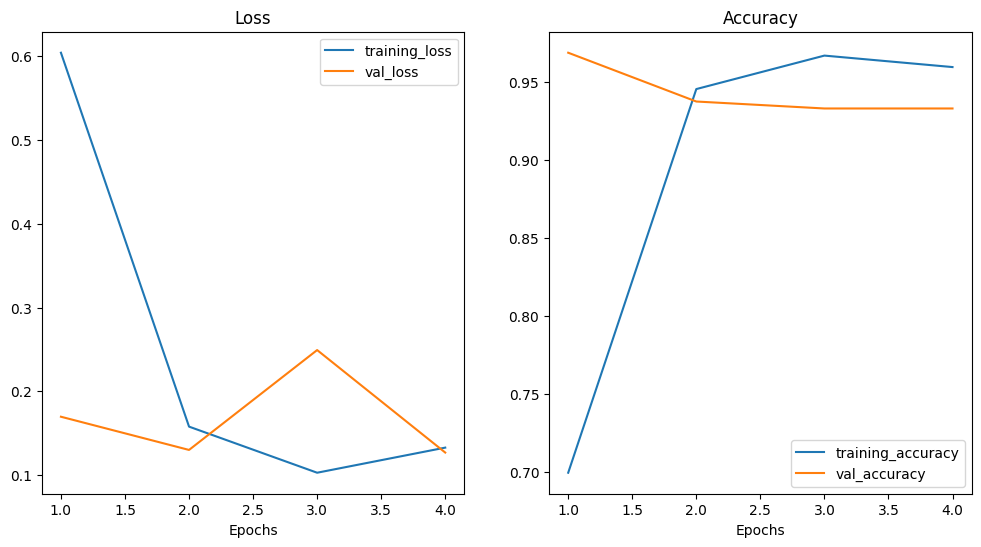

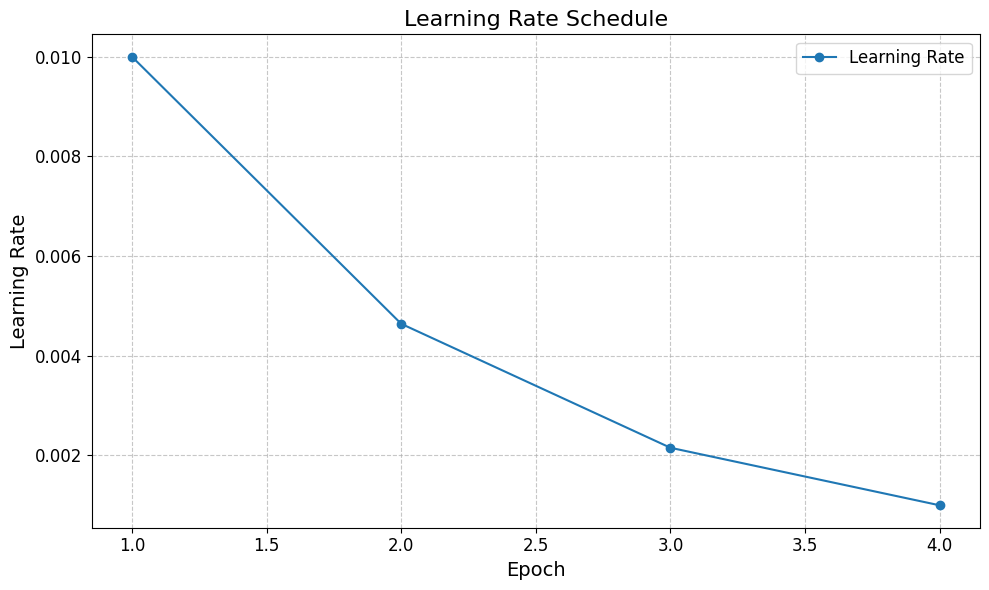

In [23]:
plot_loss_curves(history)

In [24]:
test_model(classifier, (cat_test_dataset, dog_test_dataset))

Model Evaluation...
Dataset A Testing Loss | Accuracy
19/19 [==============================] - 1s 44ms/step - loss: 4.5221 - accuracy: 0.9698
Dataset B Testing Loss | Accuracy
19/19 [==============================] - 1s 44ms/step - loss: 7.4910 - accuracy: 0.2533


{'Dataset_A': [4.5220770835876465, 0.9697986841201782],
 'Dataset_B': [7.491041660308838, 0.25333333015441895]}

### Train With Second Dataset

In [25]:
weights = classifier.get_weights()
cloned_model = AnimalClassifier(input_feature=INPUT_SHAPE, output_dimension=output_dim) 
cloned_model.model =  tf.keras.models.clone_model(classifier.model)
cloned_model.model.set_weights(weights=weights)

In [26]:
# 先觀查 fisher matrix 的值
fisher_diagonal = compute_fisher(cloned_model, cat_train_dataset, 30)

[==================================================>] 30/30

In [27]:
# 定義一個函數來展平所有張量並接成一個長向量
def flatten_and_concatenate_tensors(tensors):
    # 展平所有張量
    flattened_tensors = [tf.reshape(tensor, [-1]) for tensor in tensors]
    # 將展平的張量接成一個長向量
    concatenated_tensor = tf.concat(flattened_tensors, axis=0)
    return concatenated_tensor

flatten_fisher_tensors = flatten_and_concatenate_tensors(fisher_diagonal)
flatten_fisher_vectors = flatten_fisher_tensors.numpy()

hist, bin_edges = np.histogram(flatten_fisher_vectors, bins=1000, range=(flatten_fisher_vectors.min(), 1e-1))

hist[:10], bin_edges[:10]

(array([62320,  2879,  1144,   542,   342,   217,   122,   101,    82,
           71], dtype=int64),
 array([0.e+00, 1.e-04, 2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04,
        8.e-04, 9.e-04], dtype=float32))

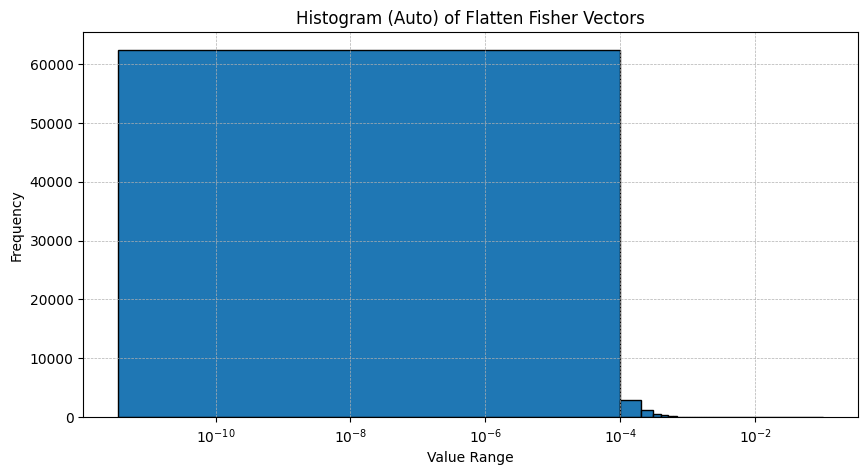

In [28]:
plt.figure(figsize=(10, 5))
plt.hist(flatten_fisher_vectors, bins=1000, range=(flatten_fisher_vectors.min(), 1e-1), edgecolor='black')

plt.xscale('log')
plt.xlabel('Value Range')
plt.ylabel('Frequency')
plt.title('Histogram (Auto) of Flatten Fisher Vectors')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [29]:
# tf.keras.models.save_model(classifier, 'three_cats_classifier')

INFO:tensorflow:Assets written to: three_cats_classifier\assets


INFO:tensorflow:Assets written to: three_cats_classifier\assets


In [30]:
def custom_loss_fn(y_true, y_pred):
    loss_fn = CategoricalCrossentropy()
    loss = loss_fn(y_true, y_pred)

    return loss

loaded_classifier = tf.keras.models.load_model(
    'three_cats_classifier', 
    custom_objects={
        'MobileNetClassifier': AnimalClassifier, 
        'custom_loss_fn': custom_loss_fn
    }
)

In [31]:
test_model(loaded_classifier, (cat_test_dataset, dog_test_dataset))

Model Evaluation...
Dataset A Testing Loss | Accuracy
19/19 [==============================] - 2s 44ms/step - loss: 4.5221 - accuracy: 0.9698
Dataset B Testing Loss | Accuracy
19/19 [==============================] - 1s 44ms/step - loss: 7.4910 - accuracy: 0.2533


{'Dataset_A': [4.5220770835876465, 0.9697986841201782],
 'Dataset_B': [7.491041660308838, 0.25333333015441895]}

In [44]:
# Set seed for experiments reproductivity
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.backend.clear_session()

# Parameters for data loading, learning rate scheduler and model training
IMG_SIZE         = 224
INPUT_SHAPE      = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE       = 8
output_dim       = 3
val_split        = 0.1

# Learning rate and scheduler parameters
epochs           = 10    # total epochs
start_opt        = 1     # decay learning rate after certain epoch 
scheduler_type   = 'cosine_annealing'
init_lr          = 5e-3
min_lr           = 5e-6
# Parameter for step scheduler
step_num         = -1
# Parameters for cosine annealing scheduler
warmup_iters     = 4
alpha            = 0.5
factor           = 2
# Parameter for exponential scheduler
decay_rate       = -1
# Parameters for model unfreezing
fine_tune_epoch  = -1     # unfreeze layers of base model after certain epoch 
unfreeze_ratio   = 0.1 
stop_epochs      = 2     # early stopping while encounter n epochs

show_config(
    image_size       = IMG_SIZE,
    dataset_shape    = INPUT_SHAPE,
    batch_size       = BATCH_SIZE,
    init_lr          = init_lr,  
    total_epochs     = epochs, 
    start_opt        = start_opt,
    fine_tune_epoch  = fine_tune_epoch,
    output_dim       = output_dim, 
    validation_split = val_split, 
    scheduler_type   = scheduler_type, 
    stop_epochs      = stop_epochs, 
    IMAGES_PATH      = IMAGES_PATH.name, 
    train_val_path   = TRAIN_VAL_PATH.name, 
    test_path        = TEST_PATH.name
)

weights = classifier.get_weights()
cloned_model = AnimalClassifier(input_feature=INPUT_SHAPE, output_dimension=output_dim) 
cloned_model.model =  tf.keras.models.clone_model(classifier.model)
cloned_model.model.set_weights(weights=weights)

lr_scheduler = get_lr_scheduler(
    initial_lr         = init_lr, 
    min_lr             = min_lr, 
    total_iters        = epochs,
    step_num           = step_num,
    scheduler_type     = scheduler_type,
    warmup_total_iters = warmup_iters,
    decay_rate         = decay_rate,
    alpha              = alpha,
    factor             = factor
)

increment_history, increment_test_results, gradient_matrix = train_increment(
    model                 = cloned_model, 
    epochs                = epochs, 
    initial_learning_rate = init_lr,
    fine_tune_epoch       = fine_tune_epoch, 
    start_opt             = start_opt,  
    prior_train_dataset   = cat_train_dataset,
    train_dataset         = dog_train_dataset, 
    val_dataset           = dog_val_dataset, 
    test_datasets         = (cat_test_dataset, dog_test_dataset), 
    unfreeze_ratio        = unfreeze_ratio, 
    lr_scheduler          = lr_scheduler, 
    patience_for_stopping = stop_epochs,
    apply_ewc             = True,
    ewc_lambda            = 0.8, 
    ewc_samples           = 30, 
    apply_fim             = True,
    fim_threshold         = 1e-15,
    apply_IncDet          = False,
    IncDet_threshold      = 1e-40
)

Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|               image_size |                                      224|
|            dataset_shape |                            (224, 224, 3)|
|               batch_size |                                        8|
|                  init_lr |                                    0.005|
|             total_epochs |                                       10|
|                start_opt |                                        1|
|          fine_tune_epoch |                                       -1|
|               output_dim |                                        3|
|         validation_split |                                      0.1|
|           scheduler_type |                         cosine_annealing|
|              stop_epochs |                                 

In [ ]:
# tf.keras.models.save_model(cloned_model, 'three_final_classifier')

INFO:tensorflow:Assets written to: three_final_classifier\assets


INFO:tensorflow:Assets written to: three_final_classifier\assets


In [43]:
del cloned_model

In [46]:
gradient_matrix

[<tf.Tensor: shape=(1024, 64), dtype=bool, numpy=
 array([[False,  True, False, ...,  True, False, False],
        [False,  True, False, ...,  True, False, False],
        [False,  True, False, ...,  True, False, False],
        ...,
        [False,  True, False, ...,  True, False, False],
        [False,  True, False, ...,  True, False, False],
        [False,  True, False, ...,  True, False, False]])>,
 <tf.Tensor: shape=(64,), dtype=bool, numpy=
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False])>,
 <tf.Tensor: shape=(64, 32), dty

In [47]:
[tf.math.count_nonzero(i_tensor)  for i_tensor in gradient_matrix]

[<tf.Tensor: shape=(), dtype=int64, numpy=30104>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>,
 <tf.Tensor: shape=(), dtype=int64, numpy=831>,
 <tf.Tensor: shape=(), dtype=int64, numpy=5>,
 <tf.Tensor: shape=(), dtype=int64, numpy=271>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>,
 <tf.Tensor: shape=(), dtype=int64, numpy=55>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>]

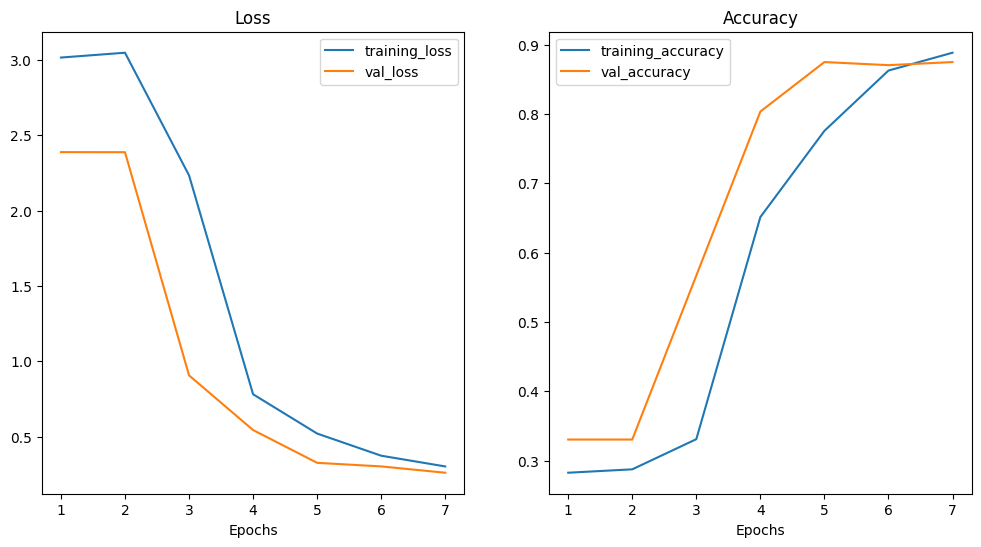

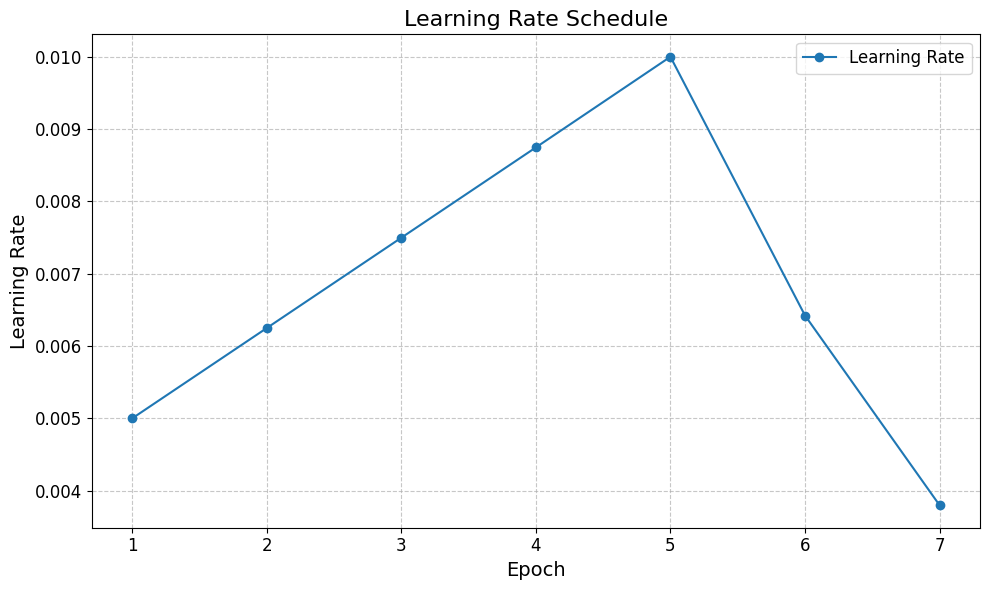

In [48]:
plot_loss_curves(history=increment_history)

In [50]:
def custom_loss_fn(y_true, y_pred):
    loss_fn = CategoricalCrossentropy()
    loss = loss_fn(y_true, y_pred)

    return loss

loaded_final_classifier = tf.keras.models.load_model(
    'three_final_classifier', 
    custom_objects={
        'MobileNetClassifier': AnimalClassifier, 
        'custom_loss_fn': custom_loss_fn
    }
)

In [51]:
test_model(loaded_final_classifier, (cat_test_dataset, dog_test_dataset))

Model Evaluation...
Dataset A Testing Loss | Accuracy
19/19 [==============================] - 2s 45ms/step - loss: 8.8365 - accuracy: 0.8221
Dataset B Testing Loss | Accuracy
19/19 [==============================] - 1s 46ms/step - loss: 8.5839 - accuracy: 0.9100


{'Dataset_A': [8.836533546447754, 0.8221476674079895],
 'Dataset_B': [8.583881378173828, 0.9100000262260437]}

# End

```python
def one_hot_encoding_(category_name: str, categories):
    index = np.where(category_name==categories)[0][0]
    one_hot = np.zeros(len(categories), dtype=int)
    one_hot[index] = 1
    
    return one_hot
```